# Evaluation of COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr

In [153]:
import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

#function to plot grid
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42


SEED = 1234
seed(SEED)
np.random.seed(SEED)

df = pd.read_csv('compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [158]:
# preparing data by selecting needed colums and removing empty values
df = df[df.columns[~df.isnull().any()]]
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
#df = df.dropna(how='any')
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


next we need to convert string data into values/ numbers to be able to use it to train, test and predict

In [159]:
#converting to values
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


0    0.549348
1    0.450652
Name: two_year_recid, dtype: float64

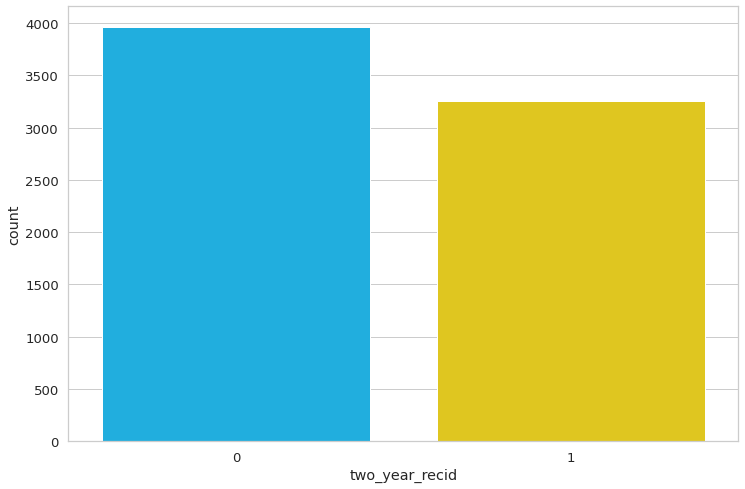

In [160]:
# with our model, we select "df.two_year_recid" column to be our ground truth
#count Plot ground truth and percentage
sns.countplot(df.two_year_recid);
df.two_year_recid.value_counts() / df.shape[0]

About 45 percent have a two year recid from the data and this is a possibility of being jailed for a smaller offense. but this does not take into account any other parameter such as race into consideration. This is just the possibility of been jailed when an offense is committed.


Next step is to divide our dataset. we cannot use the same data trained for testing so we divide the data into train and test set. we will use 0.2 percent of the training dataset as the validation set. We then need to convert them into a tensor(a set of data/ information relating to one person as relating to COMPAS) to be able to train and test with Pytorch

In [162]:
#splitting and converting data to tensor
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# X_train.astype(dtype = 'float32')
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5771, 10]) torch.Size([5771])
torch.Size([1443, 10]) torch.Size([1443])


### Building the network
From the shape above, our input data contains 10 columns.
Our network will also have two hidden layers of 5 and 3 nodes respectively

In [178]:
# Defining the model
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


In [179]:
# ann_viz(net, view=False)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)

criterion = criterion.to(device)
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1200):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

# Save model
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

epoch 0
Train set - loss: 0.698, accuracy: 0.544
Test  set - loss: 0.695, accuracy: 0.57

epoch 100
Train set - loss: 0.68, accuracy: 0.544
Test  set - loss: 0.676, accuracy: 0.57

epoch 200
Train set - loss: 0.623, accuracy: 0.544
Test  set - loss: 0.616, accuracy: 0.57

epoch 300
Train set - loss: 0.498, accuracy: 0.845
Test  set - loss: 0.489, accuracy: 0.861

epoch 400
Train set - loss: 0.427, accuracy: 0.899
Test  set - loss: 0.421, accuracy: 0.907

epoch 500
Train set - loss: 0.394, accuracy: 0.906
Test  set - loss: 0.391, accuracy: 0.907

epoch 600
Train set - loss: 0.374, accuracy: 0.906
Test  set - loss: 0.372, accuracy: 0.908

epoch 700
Train set - loss: 0.359, accuracy: 0.907
Test  set - loss: 0.357, accuracy: 0.908

epoch 800
Train set - loss: 0.347, accuracy: 0.908
Test  set - loss: 0.346, accuracy: 0.91

epoch 900
Train set - loss: 0.337, accuracy: 0.908
Test  set - loss: 0.336, accuracy: 0.91

epoch 1000
Train set - loss: 0.329, accuracy: 0.908
Test  set - loss: 0.328, a

In [238]:
# Test the model using test set
net = torch.load(MODEL_PATH)
classes = ['No Recid', 'Recid']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

    No Recid       0.89      0.96      0.92       823
       Recid       0.93      0.85      0.89       620

    accuracy                           0.91      1443
   macro avg       0.91      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9099099099099099


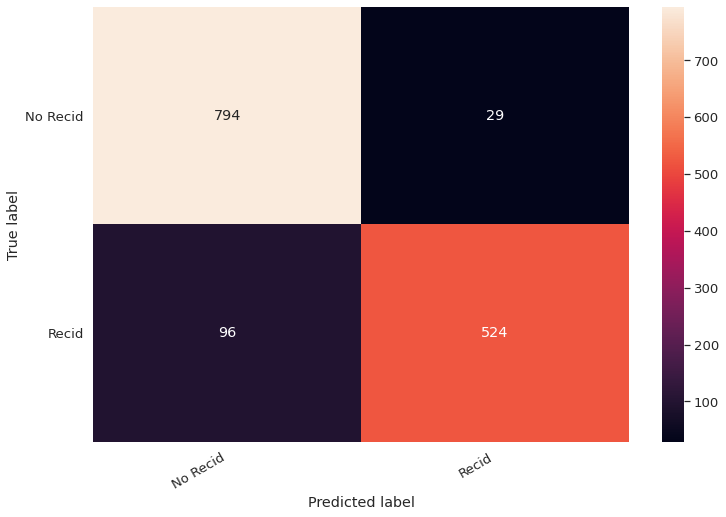

In [142]:
# Plot
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Predicting Recidivism(tendency to reoffend)
Definitions and possible parameters

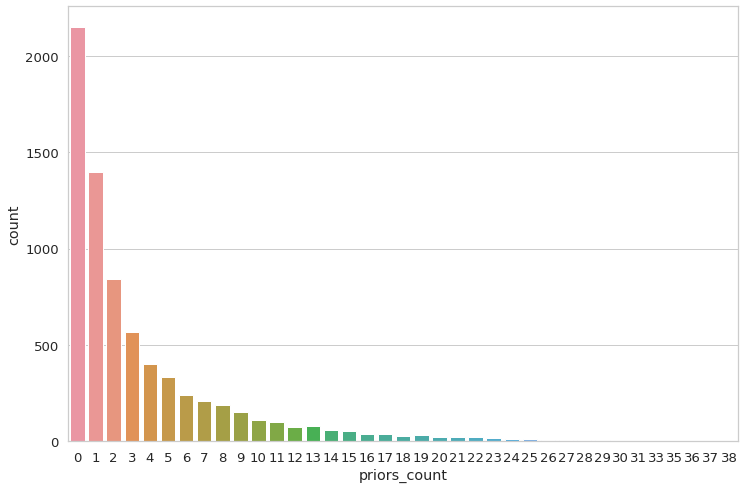

In [240]:
# graph showing prior count to help in prediction
sns.countplot(df.priors_count);


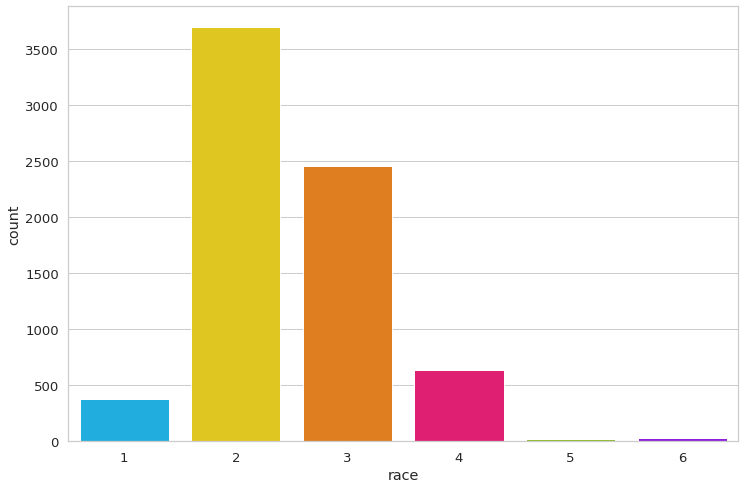

In [241]:
sns.countplot(df.race)

#### Definitions for race
        Other: 1 
        African-American: 2
        Caucasian: 3
        Hispanic: 4
        Native American: 5
        Asian: 6


In [233]:
def will_recid(sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event):
  t = torch.as_tensor([sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

# Possible values
print("sex : " + str(df.sex.unique()))
print("race : " + str(df.race.unique()))
print("age_cat : " + str(df.age_cat.unique()))
print("juv_fel_count : " + str(df.juv_fel_count.unique()))
print("juv_misd_count : " + str(df.juv_misd_count.unique()))
print("priors_count : " + str(df.priors_count.unique()))
print("c_charge_degree : " + str(df.c_charge_degree.unique()))
print("is_violent_recid : " + str(df.is_violent_recid.unique()))
print("v_decile_score : " + str(df.v_decile_score.unique()))
print("event : " + str(df.event.unique()))

sex : [1 2]
race : [1 2 3 4 5 6]
age_cat : [1 2 3]
juv_fel_count : [ 0  2  1  8  4  3  9 20  6  5 10]
juv_misd_count : [ 0  1  6 12  2  4  3  8  5 13]
priors_count : [ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]
c_charge_degree : [1 2]
is_violent_recid : [0 1]
v_decile_score : [ 1  3  6  2  5  4  9  7 10  8]
event : [0 1]



We want to determine if our model work like Propublica (same, better or worse) by predicting few instances.

1. male, african-american, greater than 45 years, 2 juvenile count,14 prior count


In [228]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=2, juv_misd_count=6, priors_count =14, 
           c_charge_degree =1, is_violent_recid =1, v_decile_score =1, event= 0)

True

In [234]:
will_recid(sex=2, race= 5, age_cat=3, juv_fel_count=1, juv_misd_count=0, priors_count =1, 
           c_charge_degree =7, is_violent_recid =0, v_decile_score =3, event= 0)

False

In [148]:
will_recid(sex=1, race= 6, age_cat=3, juv_fel_count=0, juv_misd_count=1, priors_count =0, 
           c_charge_degree =1, is_violent_recid =0, v_decile_score =1, event= 0)

False

In [152]:
will_recid(sex=1, race= 2, age_cat=3, juv_fel_count=0, juv_misd_count=1, priors_count =14, c_charge_degree =1, 
           is_violent_recid =0, v_decile_score =1, event= 0)

False

male african american with no violent rate, 1 juvenile felony count and 0 prior count and a decile score of 3


In [232]:
will_recid(sex=1, race= 5, age_cat=2, juv_fel_count=0, juv_misd_count=2, priors_count =2, c_charge_degree =0, 
           is_violent_recid =1, v_decile_score =3, event= 0)

True